<a href="https://colab.research.google.com/github/constantbourdrez/DL_ESPCI/blob/main/Protein_design_bioinfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download files and scripts.

In [1]:
!git clone https://github.com/vaiteaopuu/structural_bioinfo
!cp -r structural_bioinfo/practicals/src/ .
!cp -r structural_bioinfo/practicals/data/ .
!rm -r structural_bioinfo/
!mkdir -p out

Cloning into 'structural_bioinfo'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 216 (delta 28), reused 58 (delta 18), pack-reused 140
Receiving objects: 100% (216/216), 125.88 MiB | 23.30 MiB/s, done.
Resolving deltas: 100% (31/31), done.


# Structure-based design

## Installation

Before we start, we need to ensure that all the necessary packages are
installed.


In [1]:
# Install condacolab and py3Dmol
!pip install -q condacolab
!pip install py3Dmol

# Initialize and check condacolab
import condacolab
condacolab.install()
import condacolab
condacolab.check()

# Install OpenMM using mamba
!mamba install -q openmm
!conda install openmm
!conda install -c conda-forge pdbfixer

✨🍰✨ Everything looks OK!
✨🍰✨ Everything looks OK!
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://docs.nvidia.com/cuda/eula/index.html

done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: 

##Designing a Sequence by Hand

Let's start by designing a protein sequence manually. We'll take a wild-type
sequence and mutate it to a new sequence. Then, we'll apply these mutations to
the x-ray protein structure.


In [2]:
# Import necessary modules
from pdbfixer.pdbfixer import PDBFixer
from src.seq_io import RAA_DIC
from openmm.app import PDBFile

# Define wild-type and new sequences
wt_seq =  "NLYIQWLKDGGPSSGRPPPS"
new_seq = "NLYIQWLKDGGPSSGRPPPS"

# Generate mutations list
mutations = [f"{RAA_DIC[o]}-{i+1}-{RAA_DIC[n]}" for i, (o, n) in enumerate(zip(wt_seq, new_seq))]

# Apply mutations to the protein structure
fixer = PDBFixer(filename="./data/1l2y.pdb")
fixer.applyMutations(mutations, "A")
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)
PDBFile.writeFile(fixer.topology, fixer.positions, open("out/test-fixed.pdb", "w"))


Show the mutated structure

In [3]:
import py3Dmol
with open("out/test-fixed.pdb") as f:
    petase = "".join(line for line in f.readlines())

view = py3Dmol.view()
view.addModelsAsFrames(petase)
#view.setStyle({"cartoon": {'colorscheme':'ssPyMol'}})

# view.animate({'loop': "forward"})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Performing an Implicit Solvent Simulation

Next, we'll perform a simulation in an implicit solvent environment (Generalized
Born solvent model). This will allow us to observe the behavior of our designed
protein in a simulated environment.

We perform here a simple molecular dynamics simulation solving the equation of
motion at about room temperature.


In [4]:
# Import necessary modules
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

# Load the protein structure
pdb = PDBFile("out/test-fixed.pdb")

# Define forcefield and system parameters
forcefield = ForceField("amber14-all.xml", "implicit/gbn2.xml")
system = forcefield.createSystem(pdb.topology, nonbondedMethod=NoCutoff, nonbondedCutoff=1*nanometer, constraints=HBonds)

# Initialize the simulation
integrator = LangevinMiddleIntegrator(400*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

# Add reporters to save simulation data
simulation.reporters.append(PDBReporter("out/output.pdb", 200))
simulation.reporters.append(StateDataReporter(stdout, 200, step=True, potentialEnergy=True, temperature=True))

# Run the simulation
simulation.step(10000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
200,-2032.2766839539358,208.7066456996809
400,-1704.5613301792257,312.92584791081475
600,-1549.9891517377534,383.6304403650417
800,-1466.3933631214416,364.7702453867924
1000,-1442.9349135429627,384.03029451087235
1200,-1460.1648035439782,406.0784350731399
1400,-1357.7104307203583,402.5927928320026
1600,-1329.2730008846706,404.4170003009012
1800,-1271.2507433663377,402.0414484155107
2000,-1400.081936372099,394.4955931221764
2200,-1418.178802721177,418.61002007467073
2400,-1441.3569950287713,400.4020765566706
2600,-1484.6232573502523,366.6915948036132
2800,-1567.6861099765306,383.62145598472256
3000,-1319.2881285396907,390.23722463621846
3200,-1388.4583238213502,401.76262753830014
3400,-1340.325495434209,397.2352217549864
3600,-1277.3138727101539,407.63932427434025
3800,-1416.2264977091113,423.7442774155747
4000,-1470.2018819695504,383.8599358764961
4200,-1397.7888839052507,386.9826374418502
4400,-1446.7316467966275,420.8784335210779

## Visualizing the Structure

Finally, let's visualize the structure of our designed protein. This will give
us insights into the conformation and arrangement of the protein's backbone.

**Is your protein still folded?**

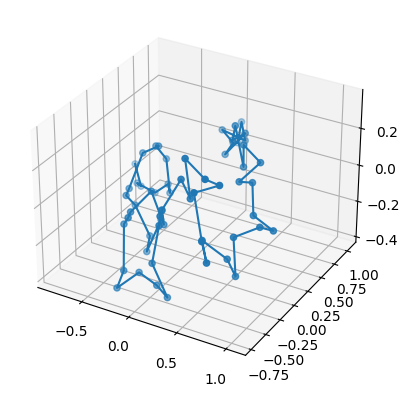

In [5]:
# Import necessary modules
import matplotlib.pyplot as plt
from openmm.app import PDBFile

# Load the protein structure
pdb = PDBFile("out/output.pdb")

# Extract backbone atom positions
bb_atoms = [i for i, el in enumerate(pdb.getTopology().atoms()) if el.name in ["N", "C", "O"]]
bb_pos = pdb.getPositions(True, frame=2)[bb_atoms, :]

# Plot the protein structure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(bb_pos[:, 0], bb_pos[:, 1], bb_pos[:, 2])
ax.plot(bb_pos[:, 0], bb_pos[:, 1], bb_pos[:, 2])
plt.show()

In [6]:
import py3Dmol
with open("out/output.pdb") as f:
    petase = "".join(line for line in f.readlines())

view = py3Dmol.view()
view.addModelsAsFrames(petase)
view.setStyle({"cartoon": {'colorscheme':'ssPyMol'}})
view.animate({'loop': "forward"})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Shallow learning: the analysis of MSAs

## Analyze MSAs
This section focuses on the analysis of Multiple Sequence Alignments (MSAs). We
start by visualizing MSAs to understand their composition and then proceed to
compute and visualize amino acid probabilities.

Read and visualize the unaligned sequences. This provides a raw view of
sequences before any alignment process.


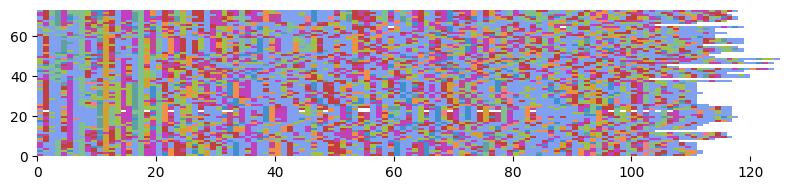

In [7]:
from src.logo import draw_msa
from src.seq_io import read_fasta
import matplotlib.pyplot as plt

# Read the fasta file containing the sequences
msa = read_fasta("./data/PF00042_seed_unaligned.txt")

# Calculate the length of each sequence
all_len = [len(s) for s in msa.values()]
max_len = max(all_len)

# Pad the sequences to ensure they have the same length for visualization
pad_seq = [s+ "-"*(max_len-len(s)) for s in msa.values()]

# Plot the padded sequences
fig, ax = plt.subplots(1, figsize=(8, 2))
draw_msa(pad_seq, ax)
plt.tight_layout()
# plt.savefig("./img/seq_plot.png")
plt.show()


Visualize the seed MSA. This gives an aligned view of the sequences,
highlighting similarities and differences.

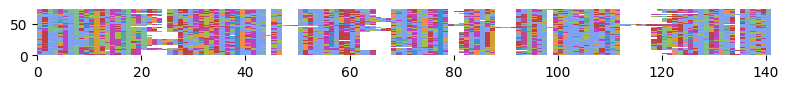

In [8]:
from src.logo import draw_msa
from src.seq_io import read_fasta
import matplotlib.pyplot as plt

# Read the fasta file containing the aligned sequences
msa = read_fasta("./data/PF00042_seed.txt")

# Plot the aligned sequences
fig, ax = plt.subplots(1, figsize=(8, 1))
draw_msa(msa, ax)
plt.tight_layout()
plt.show()


Visualize amino acid probabilities for each position in the MSA. This provides
insights into the conservation of amino acids at each position.

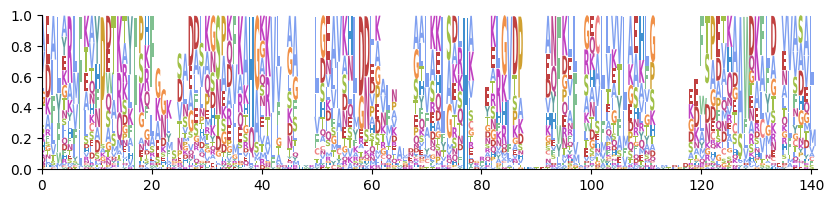

In [9]:
from src.logo import draw_msa, draw_logo
from src.seq_io import read_fasta, compute_freq, msa_2_num
import matplotlib.pyplot as plt

# Read the fasta file containing the aligned sequences
msa = read_fasta("./data/PF00042_seed.txt")

# Plot the sequence logo showcasing the amino acid probabilities
fig, ax = plt.subplots(1, figsize=(10, 2))
draw_logo(msa, ax)
plt.show()



## SVD visual

This section deals with Singular Value Decomposition (SVD), a method used to
decompose a matrix into singular vectors and singular values. We use SVD to
reduce the dimensionality of our data and visualize it, allowing us to capture
the most important features of our sequences.

Perform SVD on the MSA data and visualize the sequences in a reduced
dimensionality space using the first two principal components.


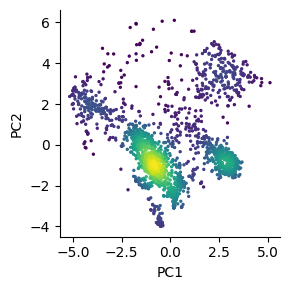

In [10]:
from src.svd.svd_analysis import SVD
from src.seq_io import read_fasta, compute_freq, msa_2_num, trim_msa
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Read the fasta file containing the sequences
msa = read_fasta("./data/PF00042_rp15.txt")
ref_name = "A0A7M7G143/184-300"
ref_seq = msa[ref_name]

# Trim the MSA sequences based on the reference sequence
msa_trim, ref_seq = trim_msa(list(msa.values()), ref_seq)

# Apply the SVD on the trimmed MSA data
proj, svd_out, pca_dir = SVD(msa_trim)

# Compute the KDE (Kernel Density Estimation) for visualization
kde = gaussian_kde(proj[:, [0, 1]].T)

# Evaluate the KDE on a regular grid
z = kde(proj[:, [0, 1]].T)

# Plot the projected sequences colored by their KDE values
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(proj[:, 0], proj[:, 1], c=z, s=2)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
for axis in ['top','right']:
    ax.spines[axis].set_visible(False)
plt.tight_layout()
plt.show()

Visualize the dominant singular vector from the SVD. This provides insights into
the most influential features or positions in the MSA sequences.


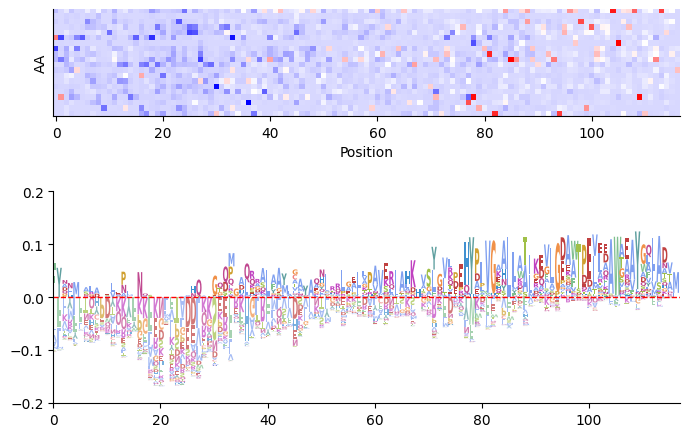

In [11]:
from src.seq_io import AA_LIST
from src.logo import draw_msa, draw_logo
fig, (ax, bx) = plt.subplots(2, figsize=(7, 5))

# Extract the dominant singular vector for visualization
vec = pca_dir[:, 0].reshape(len(ref_seq), 21)[:, :-1]

# Separate the positive and negative weights for visualization
pos = [
    [(aa, wei) for (aa, wei) in zip(AA_LIST, el) if wei >= 0]
    for el in vec
]

neg = [
    [(aa, wei) for (aa, wei) in zip(AA_LIST, el) if wei < 0]
    for el in vec
]

# Visualize the dominant singular vector and its contribution for each amino acid
ax.imshow(pca_dir[:, 0].reshape(len(ref_seq), 21)[:, :-1].T, cmap="bwr")
draw_logo(pos, bx, counts=True)
draw_logo(neg, bx, counts=True)
bx.set_ylim([-0.2, 0.2])
bx.plot([0, len(pos)], [0, 0], c="red", linestyle="--", linewidth=1)
for axis in ['top','right']:
    ax.spines[axis].set_visible(False)
ax.set_yticks([])
ax.set_ylabel("AA")
ax.set_xlabel("Position")
plt.tight_layout()
plt.show()


## Sample sequences out of the dominant eigen vectors

Generate sample sequences based on the dominant eigen vectors and visualize them
in the space of the first two principal components.


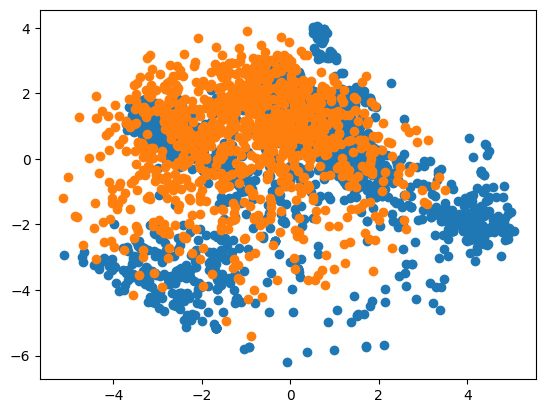

In [12]:
from src.svd.svd_analysis import encode_align, plot_pca, SVD
from src.svd.design import sample_seq
from src.seq_io import read_fasta, compute_freq, msa_2_num
import matplotlib.pyplot as plt

# Read MSA data from the fasta file
msa = read_fasta("./data/PF00042_rp15.txt")

# Generate 1000 sample sequences
designs = sample_seq(msa.values(), nb=1000)

# Apply SVD to the MSA and obtain the encoding of the MSA
proj, svd_out, pca_dir, enc_msa = SVD(msa, bmsa=True)

# Encode the sampled sequences
enc_designs = encode_align(designs)
proj_des = enc_designs @ pca_dir

# Visualize both original and sampled sequences in the reduced space
plt.scatter(proj[:, 0], proj[:, 1])
plt.scatter(proj_des[:, 0], proj_des[:, 1])
plt.show()

Visualize the distribution of amino acids in natural vs. designed sequences.

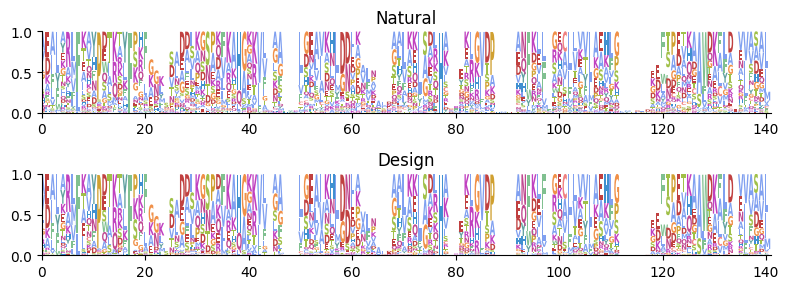

In [13]:
from src.svd.svd_analysis import encode_align, plot_pca, SVD
from src.svd.design import sample_seq
from src.seq_io import read_fasta
import matplotlib.pyplot as plt
from src.logo import draw_msa, draw_logo

# Read MSA data and generate 1000 sample sequences
msa = read_fasta("./data/PF00042_seed.txt")
designs = sample_seq(msa.values(), nb=1000)

# Visualize the distribution of amino acids
fig, (ax, bx) = plt.subplots(2, figsize=(8, 3))
draw_logo(msa, ax)
draw_logo(designs, bx)
ax.set_title("Natural")
bx.set_title("Design")
plt.tight_layout()
plt.show()

Compare the pairwise frequencies of amino acids between natural and designed
sequences to measure how close the sequences are from the natural ones.

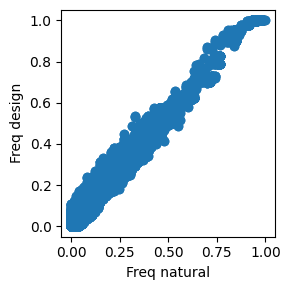

In [14]:
from src.svd.seq_io import pair_frequency
freq_nat = pair_frequency(msa, ein_f=False)
freq_design = pair_frequency(designs, ein_f=False)
fig, ax = plt.subplots(1, figsize=(3, 3))
ax.scatter(freq_nat, freq_design)
ax.set_xlabel("Freq natural")
ax.set_ylabel("Freq design")
plt.tight_layout()
plt.show()

# Deep learning

## Introduction to VAEs
Variational Autoencoders (VAEs) are powerful generative models used in deep
learning. In this section, we'll explore how to apply VAEs to protein design.

### Initializing the VAE Model
Before we can train our VAE, we need to initialize it. We'll also load our
protein sequences from a FASTA file.


In [15]:
from src.svd.vae import init_model
from src.svd.seq_io import read_fasta, encode_seq

# Read the fasta file containing the sequences
msa = read_fasta("./data/PF00042_rp15.txt")
ref_name = "A0A7M7G143/184-300"
ref_seq = msa[ref_name]

# Trim the MSA sequences based on the reference sequence
msa_trim, ref_seq = trim_msa(list(msa.values()), ref_seq)
seq_list = [seq for seq in msa_trim]
len_seq = len(ref_seq)

model = init_model(len_seq)
print(model)

VAE_seq(
  (enc_node): ModuleList(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=2457, out_features=512, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=512, out_features=128, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): Identity()
      )
    )
  )
  (enc_si): Block(
    (block): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): Identity()
    )
  )
  (dec_node): ModuleList(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=512, out_features=2457, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): Identity()
      )
    )


## Training the VAE
With our model initialized, we can now proceed to train it. We'll also visualize
the training loss to monitor the model's performance.


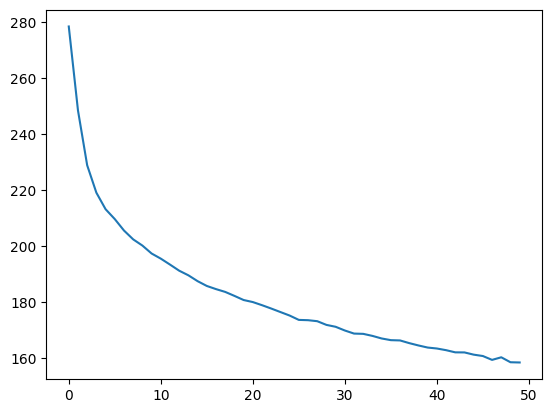

In [16]:
from src.svd.vae import train_model
import matplotlib.pyplot as plt
loss = train_model(seq_list, model, bsize=32, nb_iter=50)
plt.plot(loss)
plt.show()

## Generating Protein Sequences with VAE
Once our model is trained, we can use it to generate new protein sequences.
We'll visualize the generated sequences using a sequence logo.

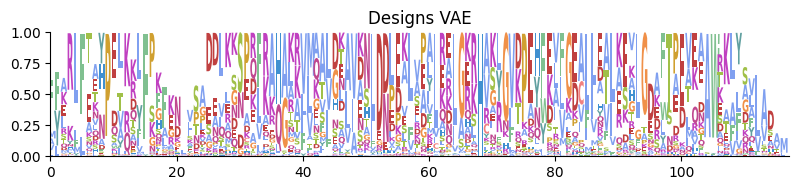

In [17]:
from src.svd.vae import generate_seq
from src.logo import draw_logo
model.eval()
nb_seq = 1000
designed = generate_seq(model, nb_seq)
fig, ax = plt.subplots(1, figsize=(8, 2))
draw_logo(designed, ax)
ax.set_title("Designs VAE")
plt.tight_layout()
plt.show()



## Analyzing Pairwise Frequencies
To understand the quality of our generated sequences, we'll compare the pairwise
frequencies of our designed sequences with the natural sequences.

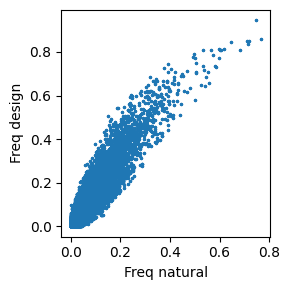

In [18]:
from src.svd.seq_io import pair_frequency
freq_nat = pair_frequency(seq_list)
freq_design = pair_frequency(designed)
fig, ax = plt.subplots(1, figsize=(3, 3))
ax.scatter(freq_nat, freq_design, s=2)
ax.set_xlabel("Freq natural")
ax.set_ylabel("Freq design")
plt.tight_layout()
plt.show()


## Visualizing the Latent Space
The latent space of a VAE provides insights into the underlying structure of the
data. We'll project our sequences into this space and visualize them using PCA.

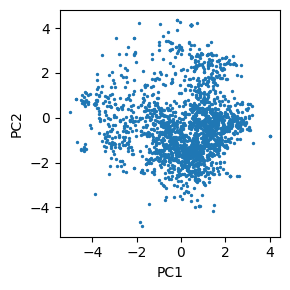

In [19]:
from src.svd.vae import MSA
import numpy as np
bin_msa = MSA(seq_list).data.detach()
mu, sig = model.encoder(bin_msa)
V, W = np.linalg.eig(np.cov(mu.detach().T))
idx = V.argsort()[::-1]
W = W[:, idx]
fig, ax = plt.subplots(1, figsize=(3, 3))
pca_proj = mu.detach() @ W
ax.scatter(pca_proj[:, 0], pca_proj[:, 1], s=2)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.tight_layout()
plt.show()
